In [39]:
%matplotlib inline

from os import listdir
from os.path import isfile, join

import sys
import subprocess
import glob
import json
import pandas as pd
import numpy as np

from collections import defaultdict
from collections import Counter

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib import rc

import pprint
pp = pprint.PrettyPrinter(indent=4)


sys.path.insert(0, '/home/cnaik/s/3/ilp/ilp_joint')
from  utils import ilp_config

In [40]:
mpl.use('pgf')

def figsize(scale):
    fig_width_pt = 469.755                          # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 10,               # LaTeX default is 10pt font.
    "text.fontsize": 10,
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "figure.figsize": figsize(1),     # default fig size of 1 textwidth
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }
mpl.rcParams.update(pgf_with_latex)

sns.set_context("paper", font_scale=1.0, rc={'lines.linewidth': 0.75,
                                             'axes.linewidth': 0.75,
                                             'text.usetex': True
                                             })
sns.set_style("whitegrid", {'font.family': 'serif',
                            'font.serif': ['Palatino']})

# sns.set(style="white")

---

In [41]:
# all_roles = ['undergoer', 'enabler', 'trigger', 'result']
all_roles = ['undergoer', 'enabler', 'trigger', 'result', 'NONE']

In [42]:
def get_gold_data(d_gold):
    gold_data_raw = defaultdict(list)
    for process_dict in d_gold:
        process = process_dict['process']
        # list of sentences
        for sentence_dict in process_dict['sentences']:
            sent_id = sentence_dict['sentenceId']
            # list of arguments
            for arg_dict in sentence_dict['annotatedArgumentSpan']:
                arg_id = arg_dict['argId']
                start_id = int(arg_dict['startIdx'])
                end_id = int(arg_dict['endIdx'])
                role_type = arg_dict['annotatedRole']
                role_label = int(arg_dict['annotatedLabel'])
                gold_data_raw[(sent_id, start_id, end_id)].append((role_type, role_label))

    gold_data = {}
    for k, v in gold_data_raw.iteritems():
        roles = []
        labels = []
        for x in v:
            roles.append(x[0])
            labels.append(x[1])

        if 1 in labels:
            gold_data[k] = roles[labels.index(1)]
        elif np.sum(labels) == -4:
            gold_data[k] = 'NONE'
    return gold_data

In [43]:
def get_prediction_data(d_predict):
    srl_data = defaultdict()
    for process_dict in d_predict:
        process = process_dict['process']
        # list of sentences
        for sentence_dict in process_dict['sentences']:
            sent_id = sentence_dict['sentenceId']
            # list of arguments
            for arg_dict in sentence_dict['predictionArgumentSpan']:
                arg_id = arg_dict['argId']
                start_id = int(arg_dict['startIdx'])
                end_id = int(arg_dict['endIdx'])
                role_type = arg_dict['annotatedRole']
                role_label = arg_dict['annotatedLabel']
                if (sent_id, start_id, end_id) in srl_data:
                    print "Key Already Present:", k
                    sys.exit()
                srl_data[(sent_id, start_id, end_id)] = arg_dict['rolePredicted']
    return srl_data

In [44]:
fold_data = {}

for f, fold_dir in enumerate(listdir(ilp_config.cross_val_dir)):
    fold_path = join(ilp_config.cross_val_dir, fold_dir)
    d_gold_file = join(fold_path, 'test', 'test.srlout.json')
    d_predict_file = join(fold_path, 'test', 'test.srlpredict.json')
    d_gold = json.load(open(d_gold_file, "r"))
    d_predict = json.load(open(d_predict_file, "r"))
    gold_data = get_gold_data(d_gold)
    srl_data = get_prediction_data(d_predict)
    analysis_data = {k: (gold_data[k], v) for k, v in srl_data.iteritems() if k in gold_data}
#     filtered_data = dict(filter(lambda x: x[1][0] in all_roles, analysis_data.items()))
    y_gold = map(lambda x: x[0], analysis_data.values())
    y_srl = map(lambda x: x[1], analysis_data.values())
    fold_data[f+1] = (y_gold, y_srl)

---

### Stats

In [45]:
def get_experiment_stats(experiment, y_gold, y_pred, f):
    macro_precision = metrics.precision_score(y_gold, y_pred, average="macro")
    macro_recall = metrics.recall_score(y_gold, y_pred, average="macro")
    macro_f1 = metrics.f1_score(y_gold, y_pred, average="macro")

    micro_precision = metrics.precision_score(y_gold, y_pred, average="micro")
    micro_recall = metrics.recall_score(y_gold, y_pred, average="micro")
    micro_f1 = metrics.f1_score(y_gold, y_pred, average="micro")

    w_precision = metrics.precision_score(y_gold, y_pred, average="weighted")
    w_recall = metrics.recall_score(y_gold, y_pred, average="weighted")
    w_f1 = metrics.f1_score(y_gold, y_pred, average="weighted")

    accuracy = accuracy_score(y_gold, y_pred)

    srl_result = {}
    macro_data = {'precision':macro_precision,
                  'recall':macro_recall,
                  'f1_score':macro_f1,
                  'accuracy':accuracy}
#     micro_data = {'precision':micro_precision,
#                   'recall':micro_recall,
#                   'f1_score':micro_f1,
#                   'accuracy':accuracy}
#     w_data = {'precision':w_precision,
#               'recall':w_recall,
#               'f1_score':w_f1,
#               'accuracy':accuracy}
    srl_result['macro'] = macro_data
#     srl_result['micro'] = micro_data
#     srl_result['weighted'] = w_data
    
#     f = str(f)
    srl_df = pd.DataFrame(srl_result)
#     t_data = [srl_df.macro.tolist(), srl_df.micro.tolist(), srl_df.weighted.tolist()]
#     arrays = [[experiment, experiment, experiment],
#               [f, f, f],
#               ['macro', 'micro', 'weighted']]
    t_data = [srl_df.macro.tolist()]
    arrays = [[experiment],
              [f],
              ['macro']]
    tuples = list(zip(*arrays))
    index = pd.MultiIndex.from_tuples(tuples, names=['experiment', 'fold', 'metric_type'])
    s = pd.DataFrame(t_data, index=index, columns=['accuracy', 'f1_score', 'precision', 'recall'])
    s = s[['precision', 'recall', 'f1_score', 'accuracy']]
    return s

In [46]:
def generate_tex_table(df, filename='out'):
    filename = filename+'.tex'
    pdffile = filename+'.pdf'
    outname = filename+'.png'

    template = r'''\documentclass[preview]{{standalone}}
    \usepackage{{booktabs}}
    \begin{{document}}
    {}
    \end{{document}}
    '''

    with open(filename, 'wb') as f:
        f.write(template.format(df.to_latex()))

    subprocess.call(['pdflatex', filename])
    subprocess.call(['convert', '-density', '300', pdffile, '-quality', '90', outname])
    print "Done!"

In [47]:
# I make my own newfig and savefig functions
def newfig(width):
    plt.clf()
    fig = plt.figure(figsize=figsize(width))
    ax = fig.add_subplot(111)
    return fig, ax

def savefig(filename):
    plt.savefig('{}.pgf'.format(filename))
    plt.savefig('{}.pdf'.format(filename))

In [48]:
for f, f_data in fold_data.iteritems():
    y_gold, y_predict = f_data
    print 'fold:\t',f
    for k, v in sorted(Counter(y_gold).items(), key=lambda x: x[0], reverse=True):
        print '\t', k, v
    print 

fold:	1
	undergoer 30
	trigger 113
	result 72
	enabler 61
	NONE 169

fold:	2
	undergoer 24
	trigger 104
	result 75
	enabler 46
	NONE 166

fold:	3
	undergoer 26
	trigger 110
	result 57
	enabler 53
	NONE 152



In [50]:
f_dfs = []
for f, f_data in fold_data.iteritems():
    y_gold, y_predict = f_data
    df = get_experiment_stats("SRL", y_gold, y_predict, f)
    f_dfs.append(df)
df = pd.concat(f_dfs)
df
# generate_tex_table(df, filename='srl')

precision    recall  f1_score  accuracy
experiment fold metric_type                                         
SRL        1    macro         0.791764  0.669761  0.711742  0.728090
           2    macro         0.835961  0.771025  0.798170  0.797590
           3    macro         0.745093  0.675452  0.703803  0.723618

In [51]:
labels = ['undergoer', 'enabler', 'trigger', 'result', 'NONE']

c_matrices = {}
for f, f_data in fold_data.iteritems():
    y_gold, y_srl = f_data
    c_matrix = confusion_matrix(y_gold, y_srl, labels)
    c_matrices[f] = c_matrix
    print 'fold',f, ": Classification Report\n"
    print(classification_report(y_gold, y_srl, target_names=labels))
    print

fold 1 : Classification Report

             precision    recall  f1-score   support

  undergoer       0.62      0.85      0.72       169
    enabler       0.89      0.56      0.69        61
    trigger       0.85      0.57      0.68        72
     result       0.84      0.77      0.80       113
       NONE       0.75      0.60      0.67        30

avg / total       0.76      0.73      0.73       445


fold 2 : Classification Report

             precision    recall  f1-score   support

  undergoer       0.73      0.83      0.78       166
    enabler       0.94      0.72      0.81        46
    trigger       0.78      0.80      0.79        75
     result       0.87      0.80      0.83       104
       NONE       0.85      0.71      0.77        24

avg / total       0.81      0.80      0.80       415


fold 3 : Classification Report

             precision    recall  f1-score   support

  undergoer       0.64      0.76      0.69       152
    enabler       0.78      0.58      0.67     

In [52]:
def plot_confusion_matrix(c_matrix, fold, filename=None):
    pgf_with_latex = {
        "axes.labelsize": 20,               # LaTeX default is 10pt font.
        "text.fontsize": 24,
        "legend.fontsize": 18,               # Make the legend/label fonts a little smaller
        "xtick.labelsize": 18,
        "ytick.labelsize": 18,
        }
    mpl.rcParams.update(pgf_with_latex)
    fig, ax = plt.subplots(figsize=(12, 9))
    sns.heatmap(c_matrix, annot=True,  fmt='',
                xticklabels=labels, yticklabels=labels,
                linewidths=1, square=True);
    ax.xaxis.set_ticks_position("bottom")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=30)
    plt.yticks(rotation=30)
    plt.title('Fold ' + str(fold) +' Confusion Matrix', fontsize=20);
    if filename:
        savefig(filename)

In [53]:
def plot_confusion_matrix2(c_matrix, ax, fold,  save=False):
    pgf_with_latex = {
        "axes.labelsize": 20,               # LaTeX default is 10pt font.
        "text.fontsize": 20,
        "legend.fontsize": 20,               # Make the legend/label fonts a little smaller
        "xtick.labelsize": 20,
        "ytick.labelsize": 20,
        }
    mpl.rcParams.update(pgf_with_latex)
    sns.heatmap(c_matrix, annot=True,  fmt='',
                xticklabels=labels, yticklabels=labels,
                linewidths=1, square=True, ax=ax, cbar=False);
    ax.xaxis.set_ticks_position("bottom")
    ax.set_xticklabels(labels, rotation=30, fontsize=20)
    ax.set_yticklabels(labels[::-1], rotation=30, fontsize=20)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title("Fold " + str(fold) + ' Confusion Matrix', fontsize=20);
    if save:
        savefig('confusion')

KeyError: 4

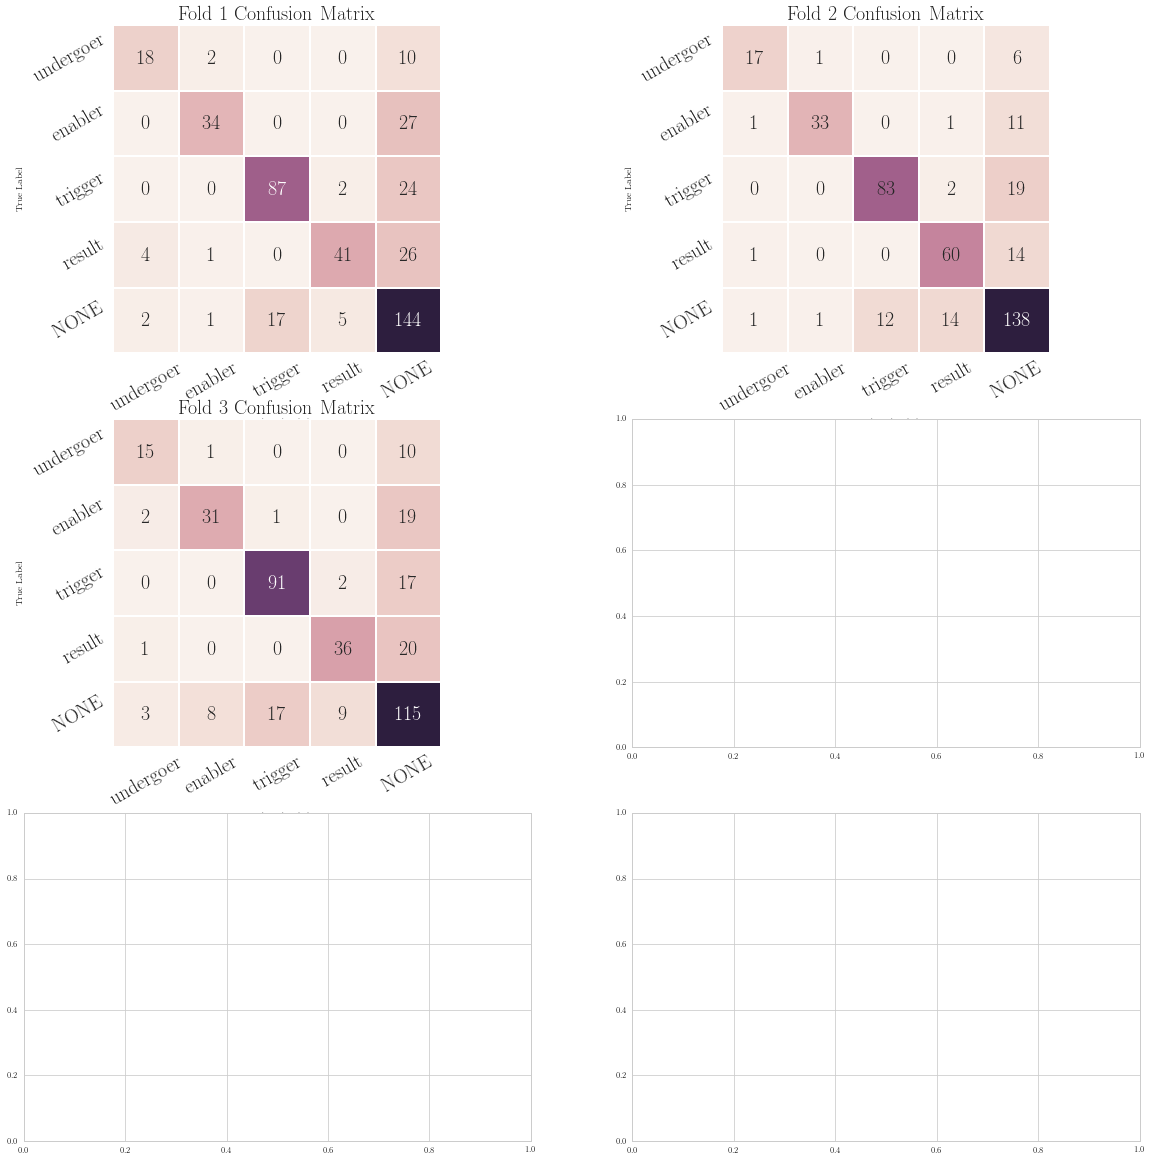

In [54]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))
plot_confusion_matrix2(c_matrices[1], ax1, "1")
plot_confusion_matrix2(c_matrices[2], ax2, "2")
plot_confusion_matrix2(c_matrices[3], ax3, "3")
plot_confusion_matrix2(c_matrices[4], ax4, "4")
plot_confusion_matrix2(c_matrices[5], ax5, "5")
fig.subplots_adjust(hspace=.8, wspace=-0.2)
ax6.axis('off')
# fig.text(0.5, 0.04, 'Predicted Label', ha='center', va='center', fontsize=24)
# fig.text(0.06, 0.5, 'True Label', ha='center', va='center', rotation='vertical', fontsize=24)
plt.show()
# fig.savefig('{}.pdf'.format('combined_confusion'))

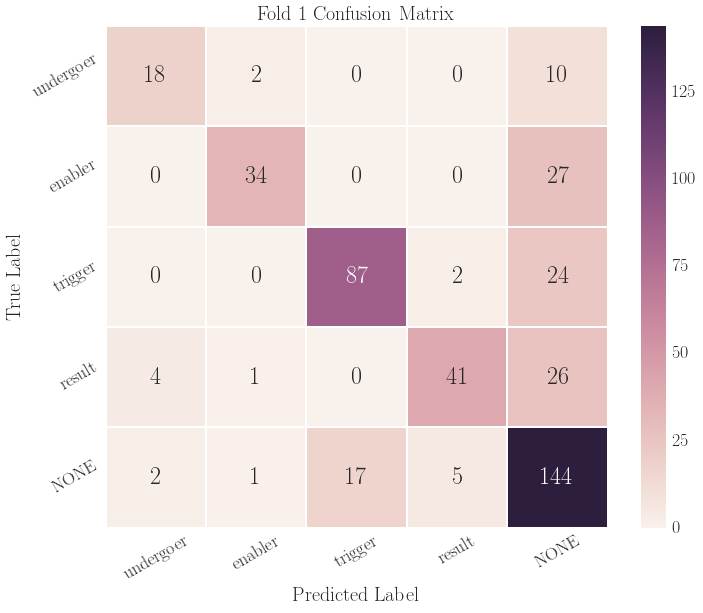

In [32]:
plot_confusion_matrix(c_matrices[1], 1, filename='fold1_confusion')

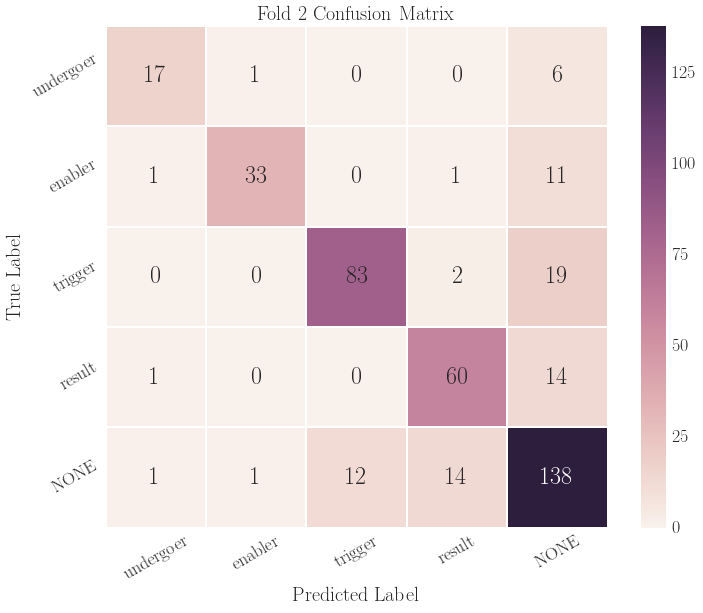

In [33]:
plot_confusion_matrix(c_matrices[2], 2, filename='fold2_confusion')

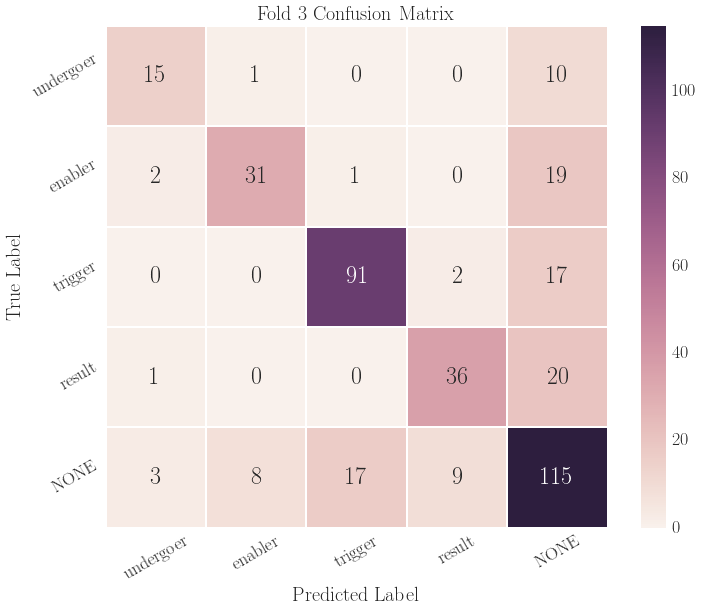

In [34]:
plot_confusion_matrix(c_matrices[3], 3, filename='fold3_confusion')

In [ ]:
plot_confusion_matrix(c_matrices[4], 4, filename='fold4_confusion')

In [ ]:
plot_confusion_matrix(c_matrices[5], 5, filename='fold5_confusion')